<a href="https://colab.research.google.com/github/pockerman/hidden_markov_modeling/blob/master/stories/story_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Story 20


### Region 5 [100000000-120000000]

In [1]:
import sys
sys.path.append("../")

In [2]:
import numpy as np
from pomegranate import *
import seaborn as sns

In [3]:
from helpers import read_configuration_file, INFO, WARNING
from train import load_regions
from hmm_helpers import build_hmm
from helpers import WindowType
from preprocess_utils import get_distributions_list_from_names as get_dist_list
from region import Region

In [4]:
from notebooks_helpers import filter_viterbi_path
from notebooks_helpers import save_segments
from notebooks_helpers import load_data_file
from notebooks_helpers import get_start_end_segment
from notebooks_helpers import make_data_array
from notebooks_helpers import gmm_clustering
from notebooks_helpers import create_viterbi_path
from notebooks_helpers import create_states
from notebooks_helpers import create_tuf_state
from notebooks_helpers import get_states_counter
from notebooks_helpers import plot_hmm_states_to_labels
from notebooks_helpers import plot_hmm_label_state
from notebooks_helpers import plot_hmm_cluster_contours

In [5]:
sns.set(color_codes=True)

Apply ```HMM_Model_3_GMM_TUF_INCREASE_DUP_NO_WGA.json``` in region ```region_0_REGION_5_5S_KEEP_OUTLIERS.txt``` [100000000-120000000]

In [6]:
# load the configuration
configuration = read_configuration_file("../config.json")
hmm_config = configuration["HMM"]
hmm_filename = "HMM_Model_3_GMM_TUF_INCREASE_DUP_NO_WGA.json"
hmm_model = build_hmm(hmm_file=hmm_filename)
# visualize the model we just trained
#plt.figure( figsize=(20,18) )
#hmm_model.plot()
#plt.show()

Orphan state HMM_Model-start removed due to no edges                             leading to it
Orphan state HMM_Model-end removed due to no edges                             leading to it


In [7]:
# load the region we want to use for prediction
region_name = "region_0_REGION_5_5S_KEEP_OUTLIERS.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_5_5S_KEEP_OUTLIERS.txt
Sequence length:  200000


In [9]:
filename="viterbi_path_TUF_GMM_INCREASE_NO_WGA_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, filename=filename)

Observation length:  200000
Done. Execution time 0.7043688899975677 secs
Log-probability of ML Viterbi path:  -1308642.2537186444
Viterbi path length:  200001
There should be 0 gaps


In [10]:
# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename="tuf_delete_tuf_TUF_GMM_INCREASE_NO_WGA_D_1_" + region_name
save_segments(segments=segments, chromosome='chr1', filename=filename)

Length of path  200000
Length of TUF+DELETION+TUF state:  79


In [11]:
wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

Length of WGA Observations:  200000
Encountered gaps:  0


In [12]:
states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0}

states_counter = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

{'Duplication': 1564, 'Normal-I': 77442, 'Normal-II': 120161, 'Deletion': 199, 'Single-Deletion': 0, 'TUF': 634, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0}


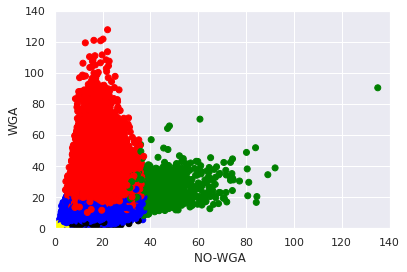

HMM labels color:  {'blue': [1, 77442], 'red': [2, 120161], 'green': [0, 1564], 'yellow': [3, 199], 'black': [5, 634]}


In [13]:
hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          xlim=(0.0, 140.), ylim=(0.0, 140.0))
print("HMM labels color: ", color_comp_assoc_hmm)

State:  Duplication
Length: 1564


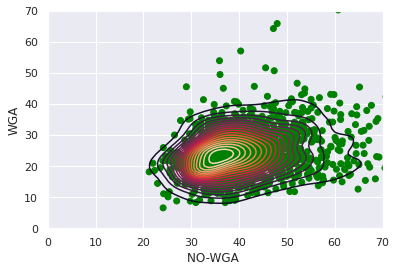

State:  Normal-I
Length: 77442


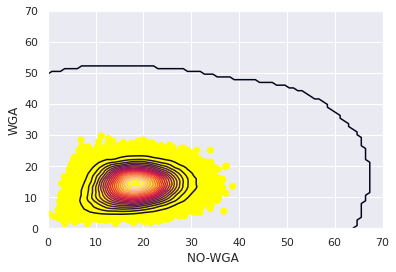

State:  Normal-II
Length: 120161


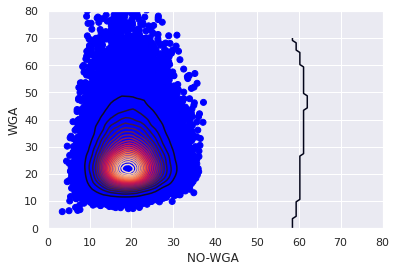

State:  Deletion
Length: 199


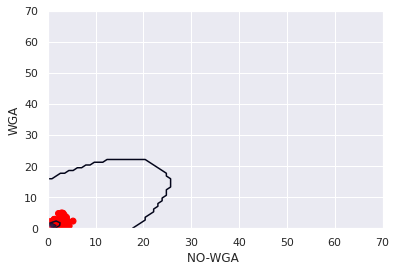

State:  Single-Deletion
For state: Single-Deletion could not plot empty observations
State:  TUF
Length: 634


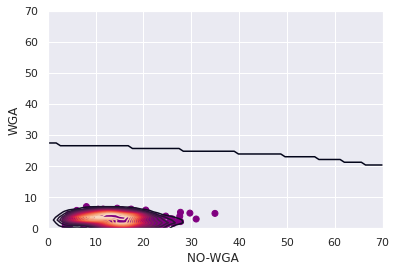

In [13]:
plot_hmm_label_state(hmm_states_to_labels=hmm_states_to_labels, hmm_labels=hmm_labels, 
                     no_wga_obs=no_wga_obs, wga_obs=wga_obs, nbins=80)

State:  Deletion
[[0.9712909764298266, 0.9589608463870823], [[1.106519440063245, 0.0], [0.0, 1.1952428859621937]]]
State:  Duplication
[[24.28366797412753, 45.0], [[39.471024811288885, 0.0], [0.0, 71.54808748205767]]]
State:  Normal-I
[[13.753028910869345, 16.65782047082554], [[19.024621058306938, 0.0], [0.0, 31.482958282497922]]]
State:  Normal-II
[[23.317594234200683, 19.64184479754624], [[52.48834045350293, 0.0], [0.0, 19.60363961959968]]]
State:  TUF
[[1.7345500646577061, 14.220263675791804], [[1.9261202863038178, 0.0], [0.0, 15.656083256828454]]]
[[1.7345500646577061, 40.0], [[1.9261202863038178, 0.0], [0.0, 15.656083256828454]]]
Weights found:  [-0.41551544 -1.07880966]
Weights:  [0.66 0.34]


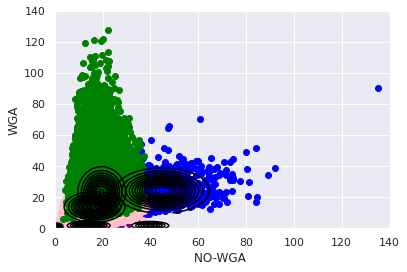

In [14]:
obs_state = {}

for state in hmm_states_to_labels:
    obs_state[state] = []

for i, obs in enumerate(observations):
        if obs != (-999.0, -999.0):
            viterbi_state = sequence_viterbi_state[i][1]
            obs_state[viterbi_state].append(obs)
            
states = hmm_model.states

state_vars = {}

for state in states:
    
    if state.name in hmm_states_to_labels:
        
        print("State: ", state.name)
        
        if state.distribution.name == "MultivariateGaussianDistribution":
            print(state.distribution.parameters)
            
            state_vars[state.name] = state.distribution.parameters
            
        elif state.name == 'TUF':
            
            state_vars[state.name] = {}
           
            for i, comp in enumerate(state.distribution.distributions):
                state_vars[state.name]["comp"+str(i)] = comp.parameters
                print(comp.parameters)
            weights = state.distribution.weights
            print("Weights found: ", weights)
            state_vars[state.name]["weights"] = np.exp(weights) 
            print("Weights: ", state_vars[state.name]["weights"])


state_colors={'TUF':"purple", "Deletion":"red",
                'Duplication':"blue", "Normal-I":"pink",
                "Normal-II":"green"}

state_min_max = {'TUF':{'min_x': 0.0, 'max_x':50.0, 'min_y': 0.0, 'max_y':10.0},
                 'Deletion':{'min_x': 0.0, 'max_x':10.0, 'min_y': 0.0, 'max_y':10.0},
                 'Normal-II':{'min_x': 0.0, 'max_x':45.0, 'min_y': 0.0, 'max_y':140.0},
                 'Normal-I':{'min_x': 0.0, 'max_x':45.0, 'min_y': 0.0, 'max_y':35.0},
                 'Duplication':{'min_x': 20.0, 'max_x':140.0, 'min_y': 10.0, 'max_y':55.0}}

plot_hmm_cluster_contours(state_colors=state_colors, state_vars=state_vars, 
                          obs_state=obs_state, nbins=80, ncontours=14, state_min_max=state_min_max)